# Spectroscopy with XGA

This tutorial will show you how to perform basic spectroscopic analyses on XGA sources, starting with how to generate spectra for a source. Then it will be shown how the XSPEC interface may be used to fit a model to the data, and then how we can retrieve the fit results.

The use of the spectrum product view method with also be demonstrated, to produce visualisations of spectra roughly equivalent to those that XSPEC produces. 

In order to generate these spectra, XGA must interact with telescope-specific software, such as SAS for XMM and eSASS for eROSITA, therefore the user must have the appropriate software installed to interact with certain data. XGA will check for the presence of the relevant software before trying to run any routines that depend on it. 


Please note that this tutorial will cover the common XGA functionality for all telescopes. Products made from different telescopes will have certain telescope-specific quirks associated with them, that arise from interaction with their corresponding software - e.g. the way XMM's SAS generates spectra is different to the way eROSITA's eSASS does. Consequently, there will be some differing optional arguments available within XGA's built in functions that interact with these softwares. It is therefore important to read [the multi mission tutorial](multimission.ipynb), where caveats associated with interacting with telescope-specific software are detailed, along with reccomendations, and useful tips when considering data from certain telescopes. 

In [1]:
from astropy.units import Quantity
import numpy as np
import pandas as pd

from xga.samples import ClusterSample
from xga.sources import PointSource
from xga.generate.sas import evselect_spectrum
from xga.generate.esass import srctool_spectrum
from xga.xspec import single_temp_apec, power_law

/mnt/lustre/projects/astro/general/jp735/XGA_dev/XGA/xga/utils.py:39: DeprecationWarning: The XGA 'find_all_wcs' function should be imported from imagetools.misc, in the future it will be removed from utils.
  warn(message, DeprecationWarning)
/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/regions/_geometry/__init__.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .polygonal_overlap import *


First we declare both an individual point source object, and a galaxy cluster sample object; in order to show that the generation of products from individual sources and samples of sources is done in the same way. The sample of three clusters is taken from the DES-Y1 sample (Farahi et al. 2019) (to demonstrate fitting a standard absorbed plasma emission model), and an individual point source (representing a quasar) to demonstrate the fitting of a redshift dependant absorbed power law):

In [6]:
# Setting up the column names and numpy array that go into the Pandas dataframe
column_names = ['name', 'ra', 'dec', 'z', 'r500', 'richness', 'richness_err']
cluster_data = np.array([['DEMO-1', 40.912, -48.561, 0.495, 2.539, 138.504, 4.243],
                         ['DEMO-2', 41.353, -53.029, 0.300, 4.720, 150.571, 4.141],
                         ['DEMO-3', 43.565, -58.953, 0.428, 3.292, 221.674, 5.713]])

sample_df = pd.DataFrame(data=cluster_data, columns=column_names)
sample_df[['ra', 'dec', 'z', 'r500', 'richness', 'richness_err']] = \
    sample_df[['ra', 'dec', 'z', 'r500', 'richness', 'richness_err']].astype(float)

# Defining the sample of four DES galaxy clusters
demo_smp = ClusterSample(sample_df["ra"].values, sample_df["dec"].values, sample_df["z"].values, 
                         sample_df["name"].values,
                         r500=Quantity(sample_df["r500"].values, 'arcmin'), 
                         richness=sample_df['richness'].values, 
                         richness_err=sample_df['richness_err'].values,
                         search_distance={'erosita': Quantity(2, 'deg')})

# Here a point source object for a quasar at z~0.8 is defined
demo_src = PointSource(176.1958, -43.1497, 0.83, name='J114447.77-430859.3', 
                       search_distance={'erosita': Quantity(2, 'deg')})

Declaring BaseSource Sample:   0%|          | 0/3 [00:00<?, ?it/s]/mnt/lustre/projects/astro/general/jp735/XGA_dev/XGA/xga/sources/base.py:188: UserWarning: A dictionary of search distances that did not contain all requested telescopes has been passed, default values have been used for the missing telescopes.
  matches, excluded = separation_match(ra, dec, search_distance, telescope)
Declaring BaseSource Sample:  33%|███▎      | 1/3 [00:02<00:05,  2.59s/it]/mnt/lustre/projects/astro/general/jp735/XGA_dev/XGA/xga/sources/base.py:188: UserWarning: A dictionary of search distances that did not contain all requested telescopes has been passed, default values have been used for the missing telescopes.
  matches, excluded = separation_match(ra, dec, search_distance, telescope)
Declaring BaseSource Sample:  67%|██████▋   | 2/3 [00:03<00:01,  1.85s/it]/mnt/lustre/projects/astro/general/jp735/XGA_dev/XGA/xga/sources/base.py:188: UserWarning: A dictionary of search distances that did not contain

/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/regions/core/compound.py:93: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = self.operator(*np.array(padded_data, dtype=np.int))
/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/regions/core/compound.py:93: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify th

## Generating spectra for our sources

It is just as simple to generate spectra (both for sample objects and source objects) as it is to generate the photometric products that we used in the last tutorial. The primary extra information required by spectral generation functions is a region in which to generate the spectra, for a galaxy cluster it might be an overdensity radius (like R$_{200}$ for instance), for a point source we would use the 'point' region, as defined on point source initilisation with the ``point_radius`` keyword argument.

You can also set the level of grouping that you want to be applied to the spectrum, using the ``min_counts`` and ``min_sn`` keyword arguments. 

For **XMM** observations we use the `evselect_spectrum` function. 

In [7]:
# For the quasar, we want to use the point region type
demo_src = evselect_spectrum(demo_src, 'point')

# Whereas for my sample of clusters I've decided I want to use the R500 regions
demo_smp = evselect_spectrum(demo_smp, 'r500')

/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


For **eROSITA** observations `srctool_spectrum` is used.

In [8]:
# For the quasar, we want to use the point region type
demo_src = srctool_spectrum(demo_src, 'point')

# Whereas for the sample of clusters we use the R500 regions
demo_smp = srctool_spectrum(demo_smp, 'r500')

Generating products of type(s) spectrum: 100%|██████████| 3/3 [03:23<00:00, 67.93s/it]


Note that `evselect_spectrum` has additional keyword arguments to `srctool_spectrum`. To see these discussed, seek the [multi mission tutorial](multimission.ipynb). Along with the nuances of generating spectra for different telescopes.

## Generating core-excised spectra for our galaxy clusters

It is not unusual to want to measure quantities from spectra where the core of the galaxy cluster in question has been removed. It is not difficult to generate spectra like this in XGA, you simply pass an inner radius (that by default is set to zero), when calling spectral generation functions.

Here we use `evselect_spectrum()` to demonstrate, though this may be done with any spectral generation function: 

In [9]:
# Here we use evselect_spectrum to demonstrate
# Though this may be done with any spectral generation function
demo_smp = evselect_spectrum(demo_smp, demo_smp.r500, demo_smp.r500*0.15)

/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Generating products of type(s) spectrum: 100%|██████████| 15/15 [12:17<00:00, 49.19s/it]


## How do the XSPEC fits work?

A general XSPEC fitting script that in theory can deal with any model setup is populated by XGA before being run for a specific source. Then the fit, luminosity, and plotting values are extracted and read into XGA. By default, all valid spectra are simultaneously fit with the same model, making sure to link the key parameters so that the values are the result of minimising the difference of a single model to all the data.

### Spectrum Checking

As XGA finds all available data relevant to a given source, ideally a model fit using every single spectrum that we generate would be performed, in order to get the best constraints. Unfortunately, we find that it is not always wise to use every single spectrum available, as if one or more are low quality, they can drag the whole fit down with them. 

As such we implemented a cleaning stage, almost identical to that used in the existing XCS luminosity-temperature pipeline, where (optionally) XSPEC fits can be performed on all of the spectra individually, and if certain quality requirements aren't met then that spectrum won't be included in the final, simultaneous, fit. More information about the default quality checks for the [single_temp_apec](../../xga.xspec.fit.html#xga.xspec.fit.general.single_temp_apec) function can be found in the documentation, and the checks can be disabled by setting `spectrum_checking=False`. The [power_law](../../xga.xspec.fit.html#xga.xspec.fit.general.power_law) function does not currently have any spectrum checking mechanism.

### Simultaneous Fitting
The default models implemented in XGA (an absorbed plasma model, and an absorbed powerlaw) both have an extra multiplicative constant, which helps us to deal with the different normalisations of spectra from different instruments and observations. The normalisations of all the spectra are linked, then the constant of the first spectrum in the dataset is frozen at 1, and all other constants are allowed to vary freely.


In some cases, you may wish to stack spectra instead of simultaneously fitting them. This can be done by setting `stacked_spectra=True`.

### Parallelisation
Just as when we generate XGA products, this process runs in parallel, with different source fits all being executed on different cores, this is especially useful when analysing large samples of objects.

### Available Models

* `single_temp_apec` - constant\*tbabs\*apec 
* `single_temp_mekal` - constant\*tbabs\*mekal
* `multi_temp_dem`- constant\*tbabs\*wdem
* `power_law` - constant\*tbabs\*powerlaw or constant\*tbabs\*zpowerlw if there is known redshift
* `blackbody` - constant\*tbabs\*bbody or constant\*tbabs\*zbbody if there is known redshift

When using these models, if the necessary spectra have not yet been generated, these functions will generate the spectra themselves.

## Fitting models to our sources

For the quasar we fit a powerlaw, rather than any more complex model; there are two types of power law available to fit in the XGA XSPEC interface, an absorbed redshift dependant powerlaw (constant\*tbabs\*zpowerlw), and an absorbed redshift independent powerlaw (constant\*tbabs\*powerlaw). You can choose which model to fit using the ``redshifted`` keyword argument when power_law (imported from xga.xspec) is called, though of course only sources with redshift information are allowed to use the zpowerlw version.

For those sources which have redshift information, luminosity values will always be calculated after a fit is performed. A call to an XGA XSPEC function allows you to choose which energy band to calculate the luminosity in (the defaults are between 0.5-2.0keV and between 0.01-100keV).

The user may also choose a photon index to use as the start value for the XSPEC fit, using the ``start_pho_index`` parameter. The energy range of the data that is to be fit to can be selected with the ``lo_en`` and ``hi_en`` parameters, but passing Astropy quantities (the default range is 0.3-7.9keV). The hydrogen column value is taken from the source object and is (by default) frozen during the fit, this behaviour can be changed with the ``freeze_nh`` keyword argument.

In [10]:
# If spectra haven't already been generated, they will be here
demo_src = power_law(demo_src, 'point', redshifted=True)

/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/mnt/lustre/projects/astro/general/jp735/XGA_dev/XGA/xga/xspec/fit/general.py:608: UserWarning: Spectrum stacking is not currently supported for XMM, and so combined spectra will not be used for these XSPEC fits.
  sources, inn_rad_vals, out_rad_vals = _pregen_spectra(sources, outer_radius, inner_radius, group_spec, min_counts,
Running XSPEC Fits: 100%|██████████| 2/2 [00:23<00:00, 11.72s/it]


The options you can pass into the absorbed APEC plasma emission model (constant\*tbabs\*apec) are similar to those of `power_law`. Start values for the temperature and metallicity of the plasma may be passed, along with parameters which will cause the nH and metallicity values to be frozen or unfrozen during the fit process:

In [11]:
demo_smp = single_temp_apec(demo_smp, 'r500')

/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/mnt/lustre/projects/astro/general/jp735/XGA_dev/XGA/xga/xspec/fit/general.py:92: UserWarning: Spectrum stacking is not currently supported for XMM, and so combined spectra will not be used for these XSPEC fits.
  sources, inn_rad_vals, out_rad_vals = _pregen_spectra(sources, outer_radius, inner_radius, group_spec, min_counts,
Running XSPEC Fits: 100%|██████████| 6/6 [02:28<00:00, 24.67s/it]


We then fit the same model to the core-excised spectra generated previously.

In [37]:
demo_smp = single_temp_apec(demo_smp, demo_smp.r500, demo_smp.r500*0.15)

/mnt/lustre/projects/astro/general/jp735/XGA_dev/XGA/xga/xspec/fit/general.py:92: UserWarning: Spectrum stacking is not currently supported for XMM, and so combined spectra will not be used for these XSPEC fits.
  sources, inn_rad_vals, out_rad_vals = _pregen_spectra(sources, outer_radius, inner_radius, group_spec, min_counts,
<ipython-input-37-8052c74af2f0>:1: UserWarning: All XSPEC operations had already been run.
  demo_smp = single_temp_apec(demo_smp, demo_smp.r500, demo_smp.r500*0.15)


## Saving fits to disk and loading them in again

Fit results are always saved to disk, and reside in the 'XSPEC' sub-directory of the 'xga_save_path' that is set in the configuration file. There they will be saved in another sub-directory with the name of the source in question.

If you decide to declare the same source again after you have already run a fit on it, you can choose to load the old fit in by setting the ``load_fits`` keyword argument to True on declaration of the source object. By default this is False however.

## Viewing fitted spectra

Its just as easy to visualise a spectrum as it is to visualise the photometric products we explored in the last tutorial. We simply use the `view()` method on a spectrum object and a data + model plot will be shown:

/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


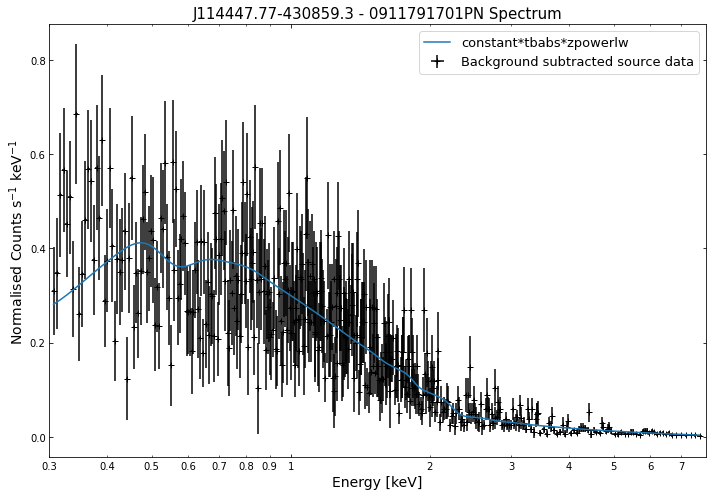

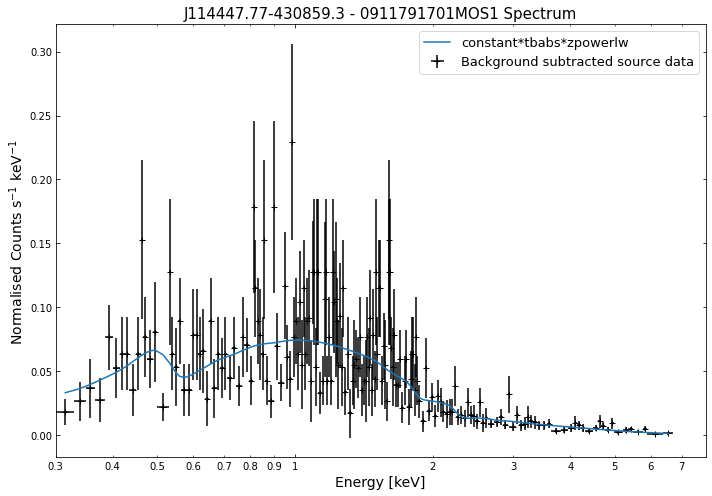

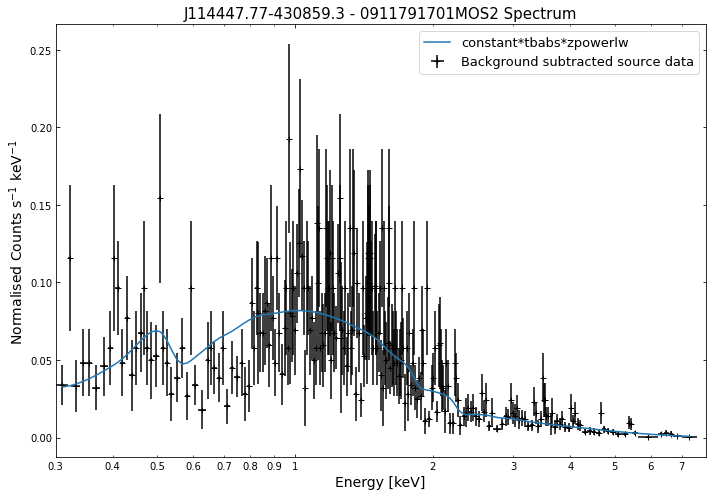

/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/fitsio/hdu/table.py:1276: FITSRuntimeWarning: Column 'F_CHAN': No maximum size: 'PI'. Column '%s': No maximum size: '%s'. %s
  warnings.warn(mess, FITSRuntimeWarning)
/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/fitsio/hdu/table.py:1276: FITSRuntimeWarning: Column 'N_CHAN': No maximum size: 'PI'. Column '%s': No maximum size: '%s'. %s
  warnings.warn(mess, FITSRuntimeWarning)
/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/fitsio/hdu/table.py:1276: FITSRuntimeWarning: Column 'MATRIX': No maximum size: 'PE'. Column '%s': No maximum size: '%s'. %s
  warnings.warn(mess, FITSRuntimeWarning)


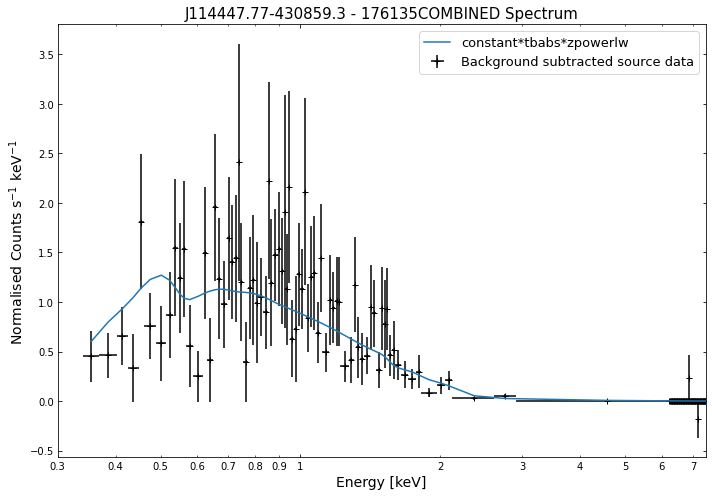

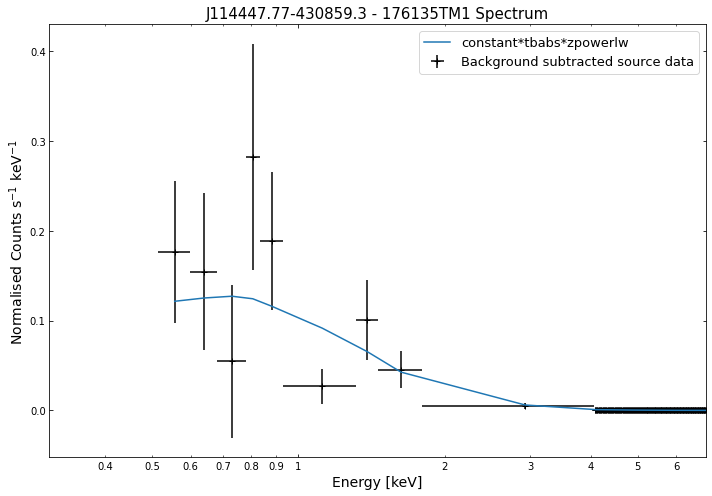

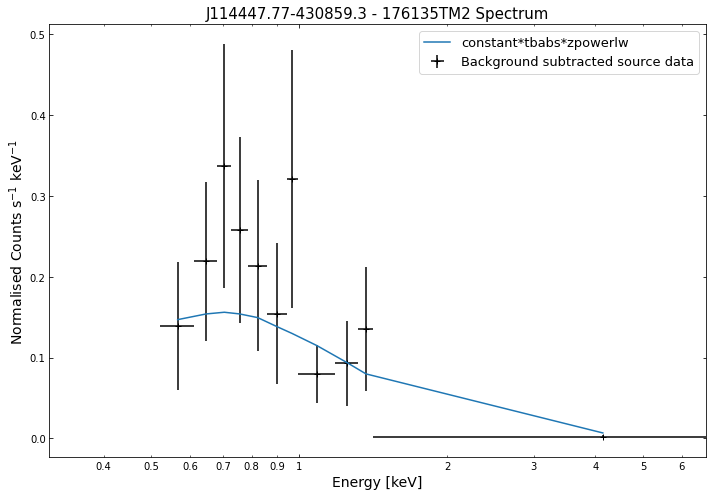

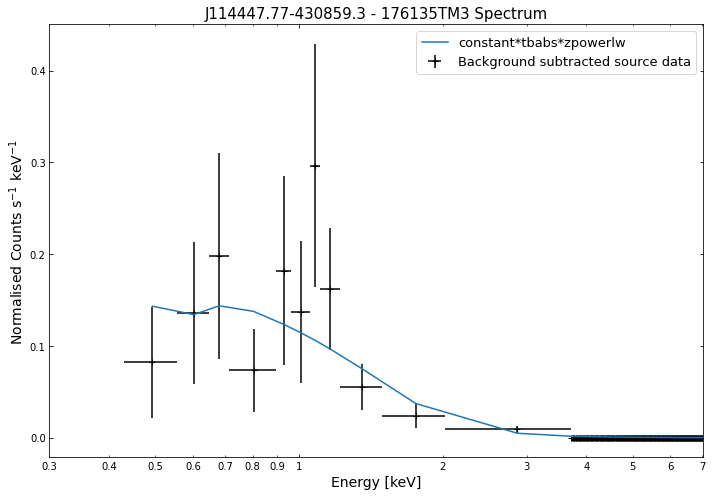

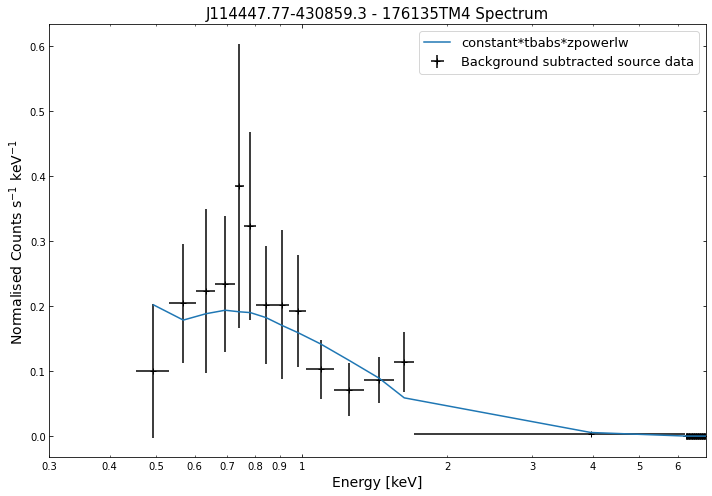

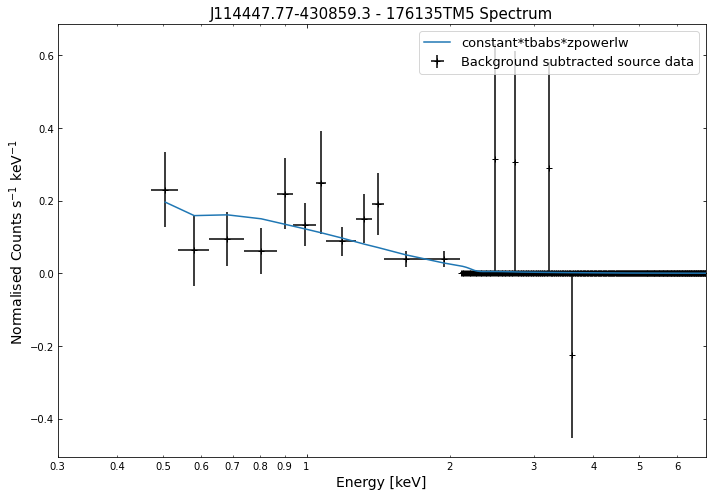

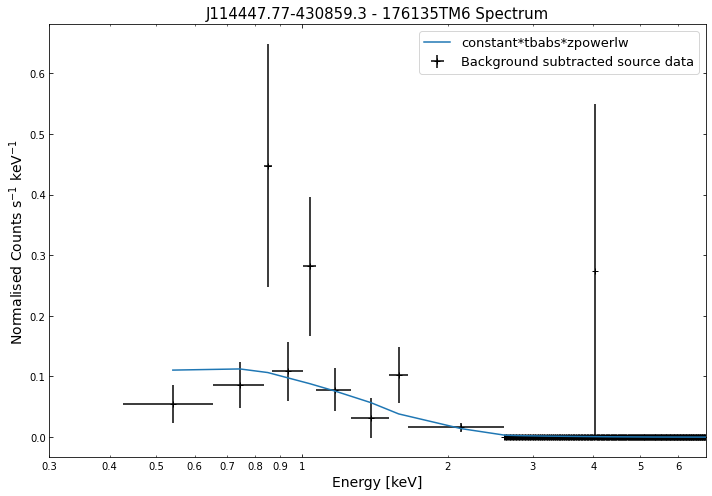

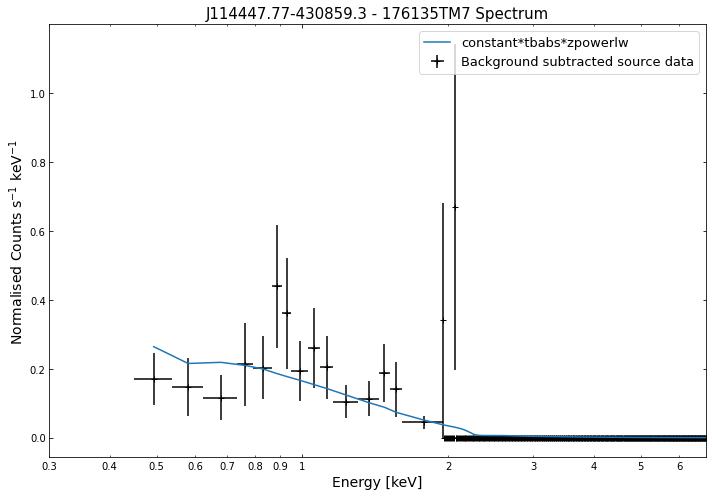

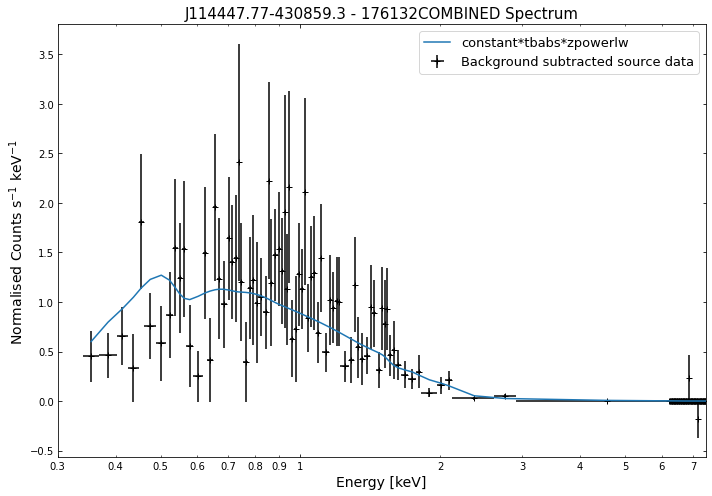

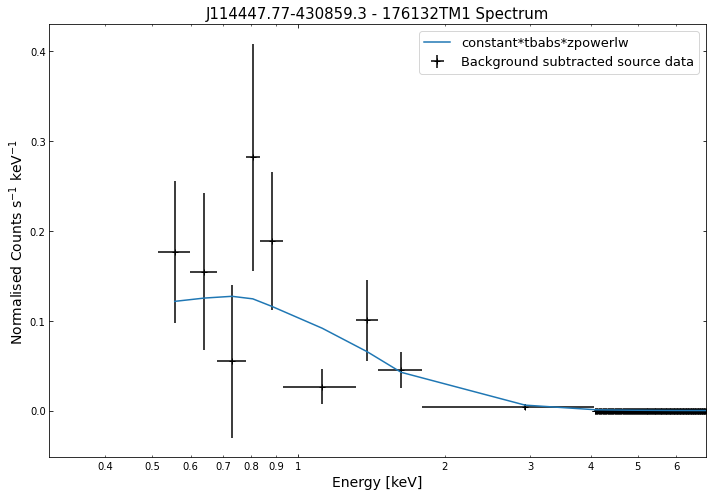

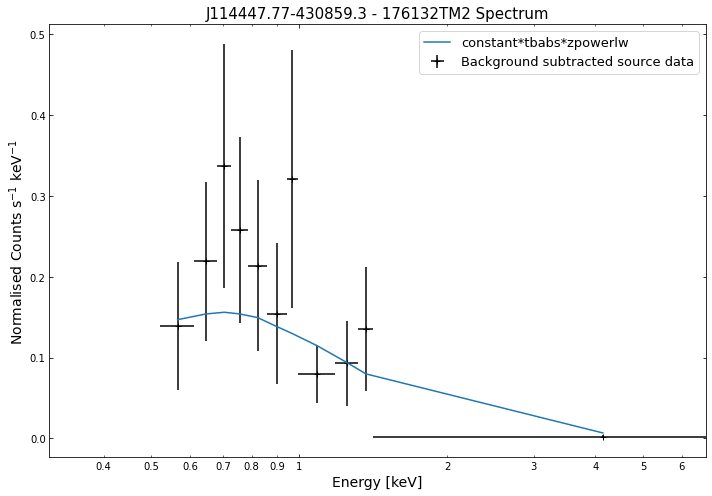

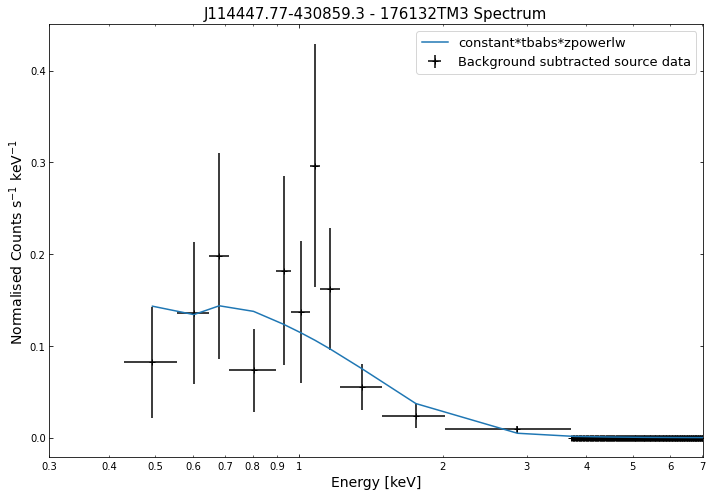

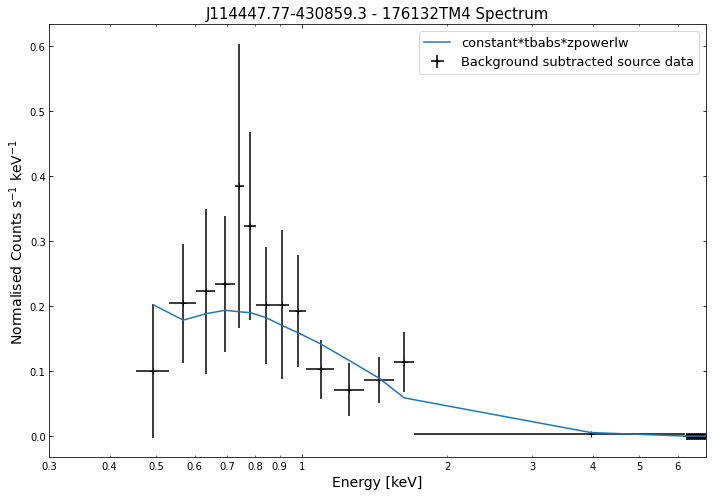

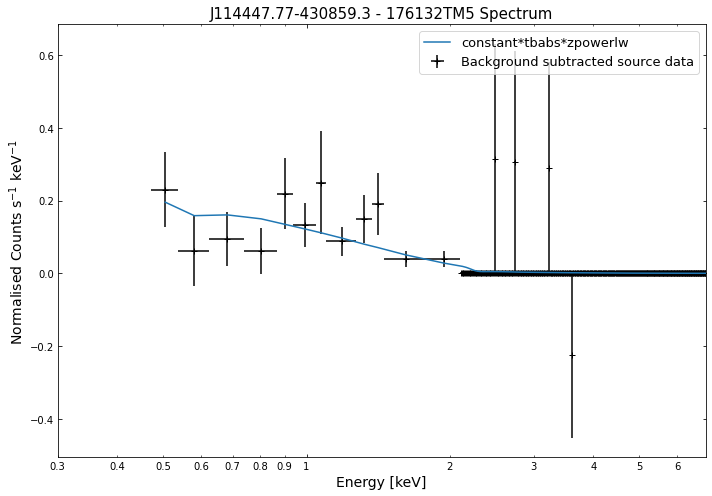

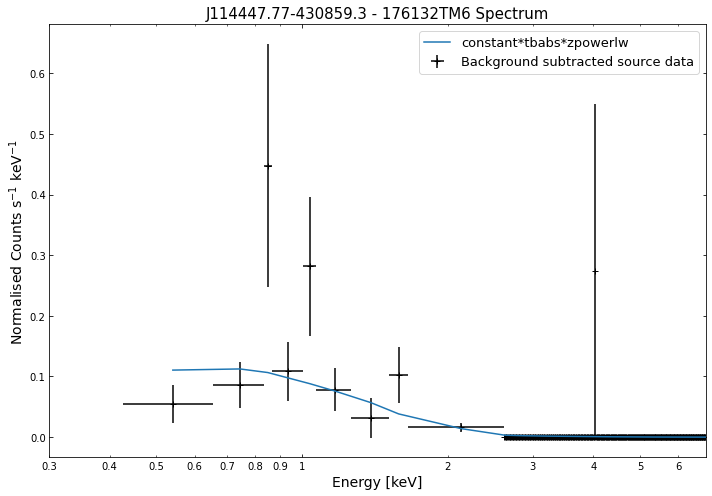

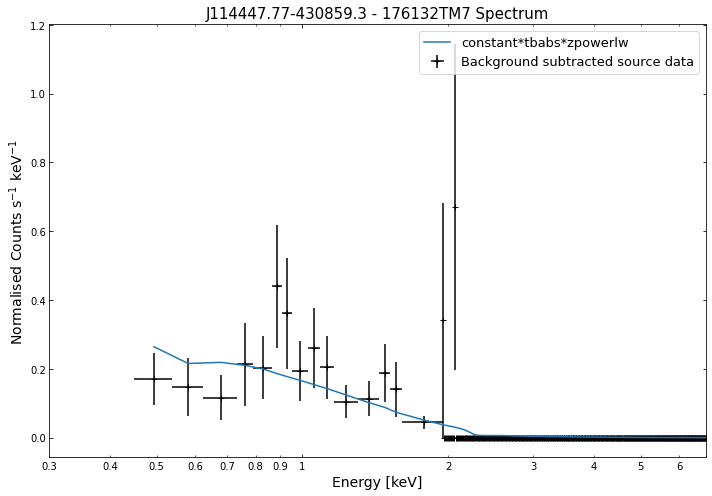

In [13]:
# Cycle through the spectra for the quasar and call their view methods
for sp in demo_src.get_spectra('point'):
    sp.view()

We do the same thing for the last cluster in our sample (DEMO-3), both for the normal R$_{500}$ and core-excised spectra:


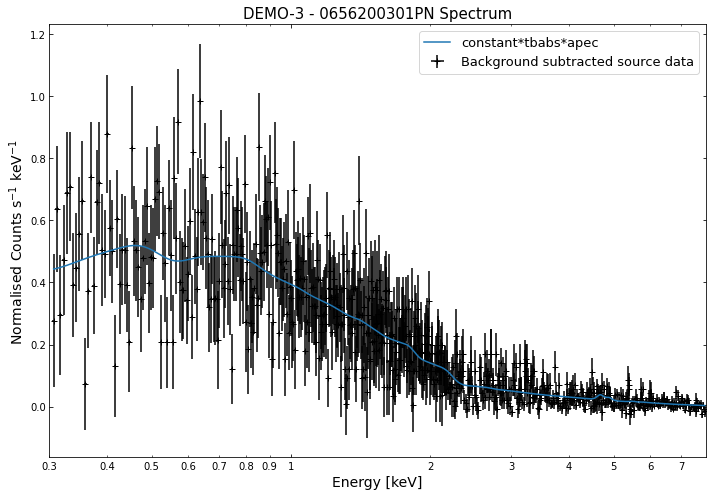

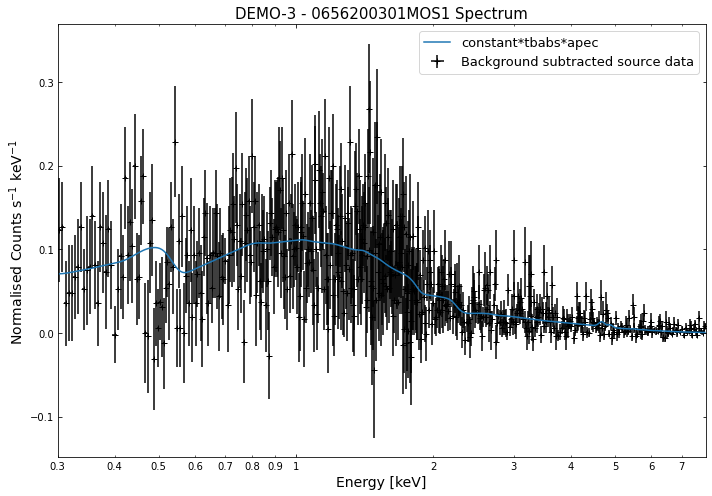

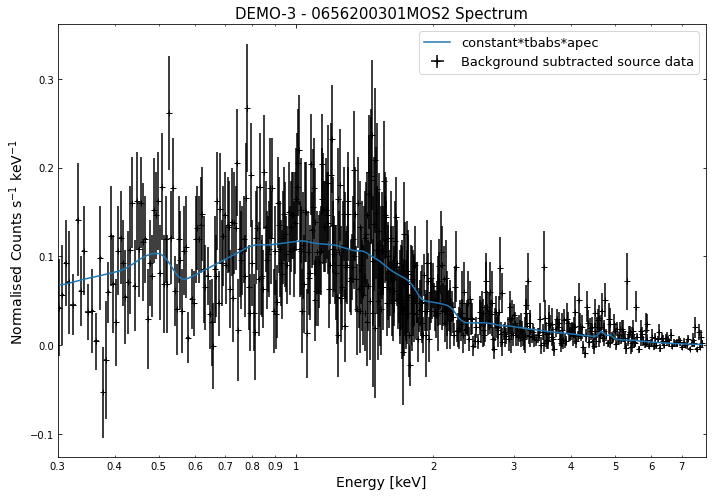

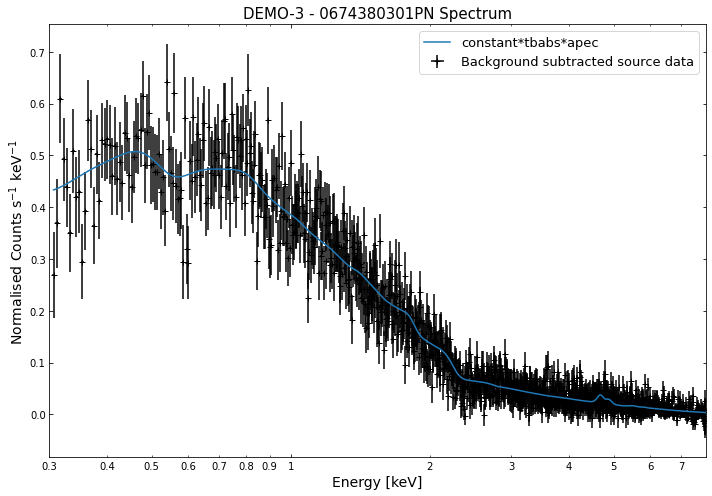

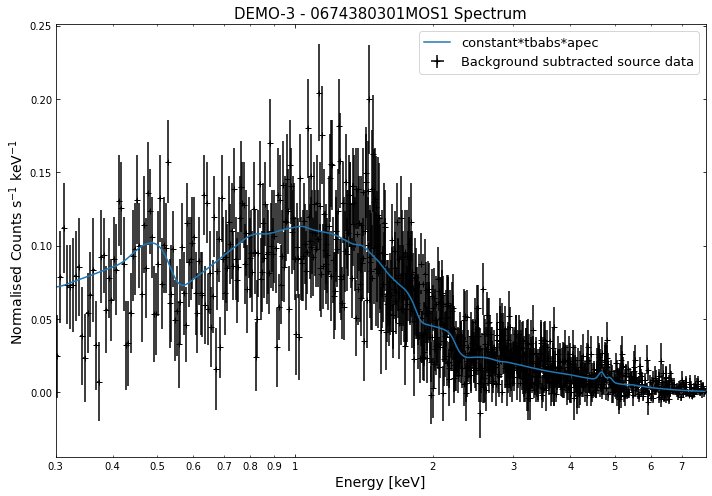

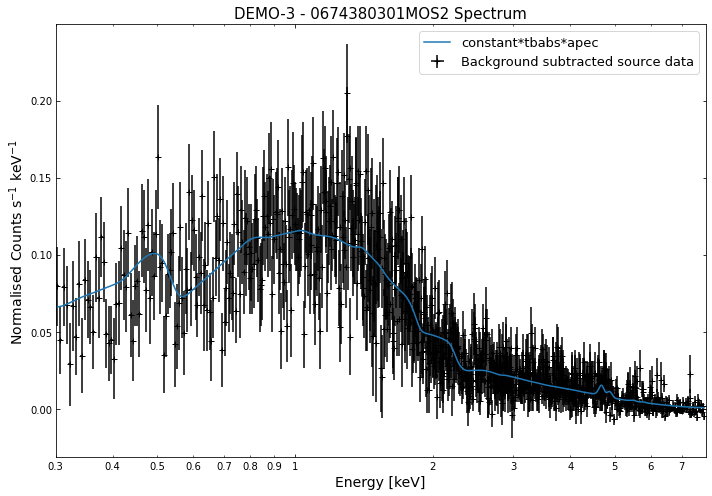

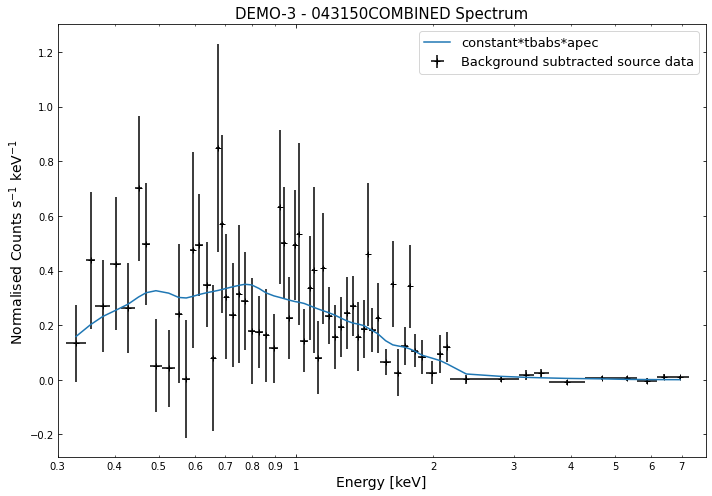

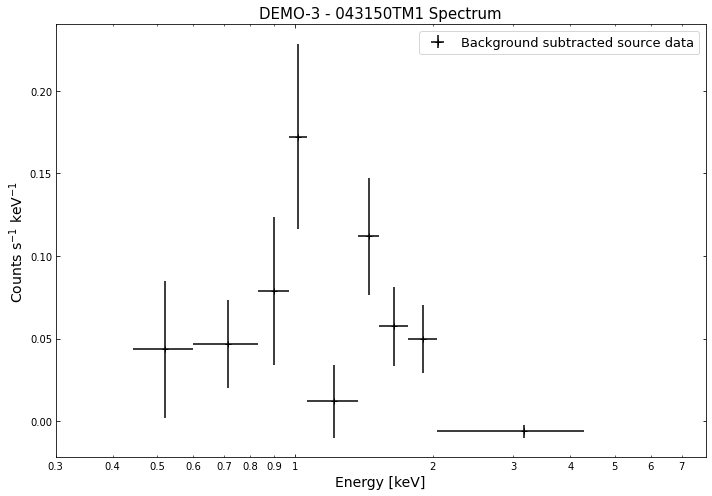

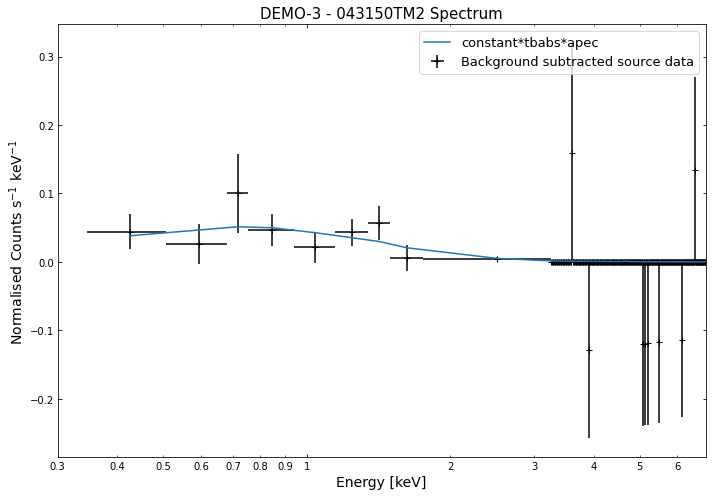

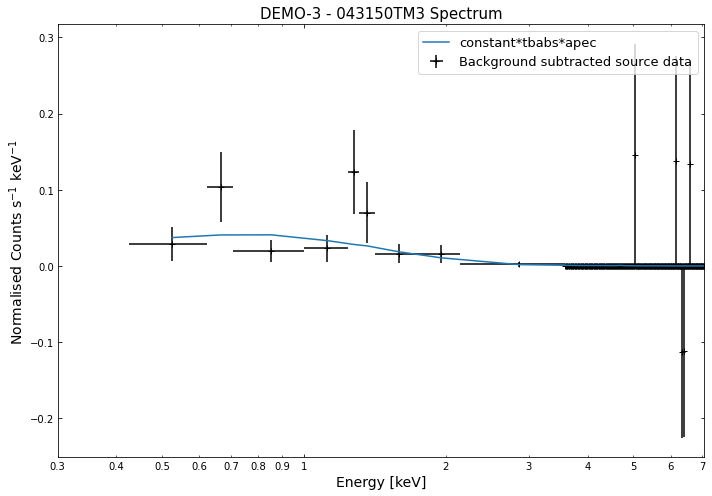

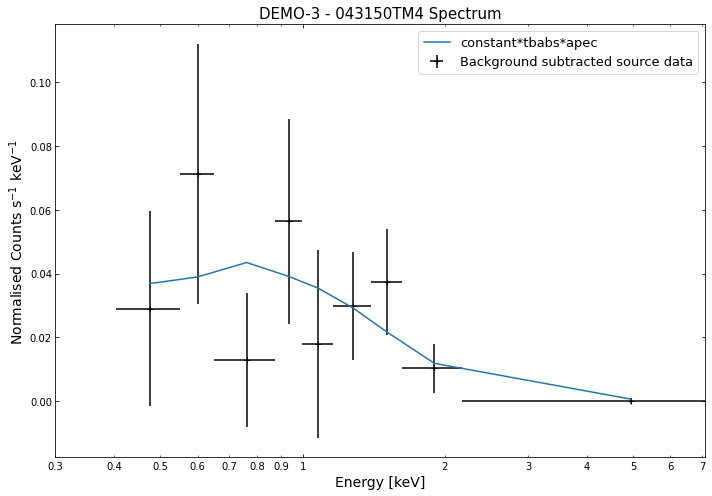

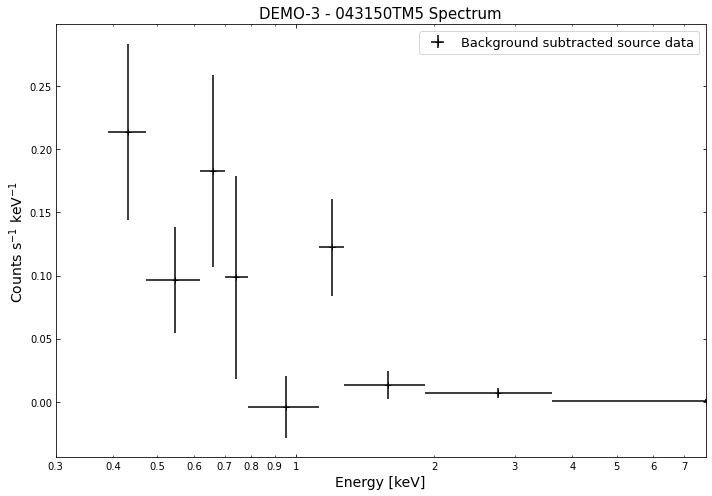

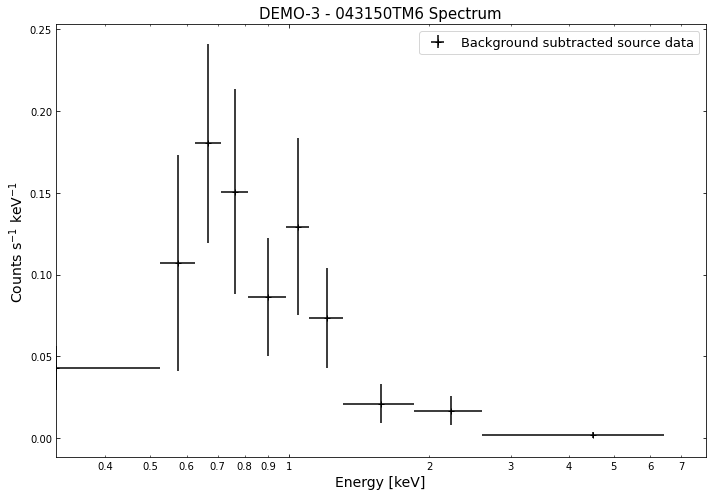

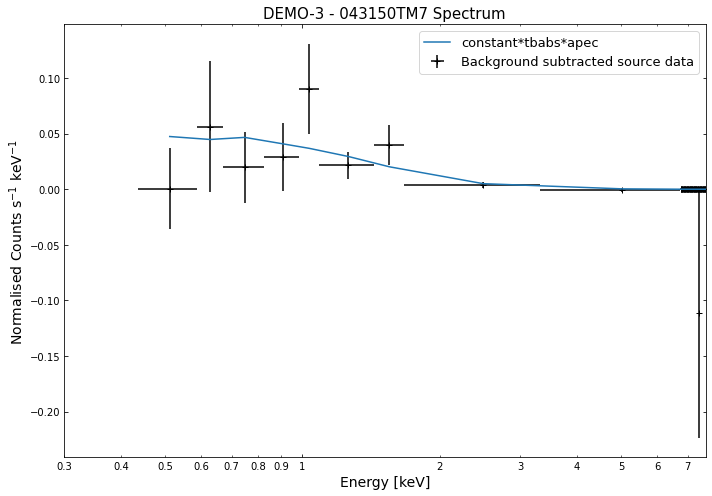

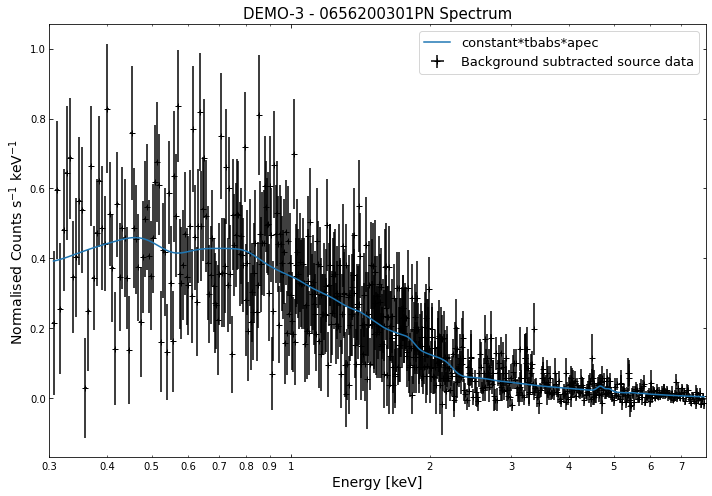

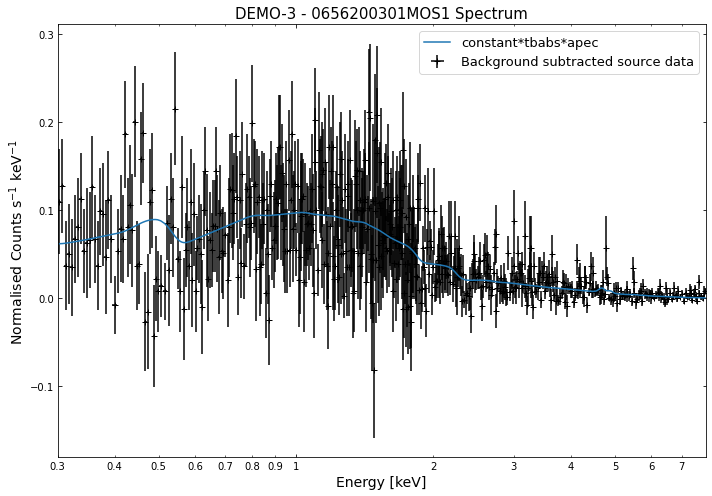

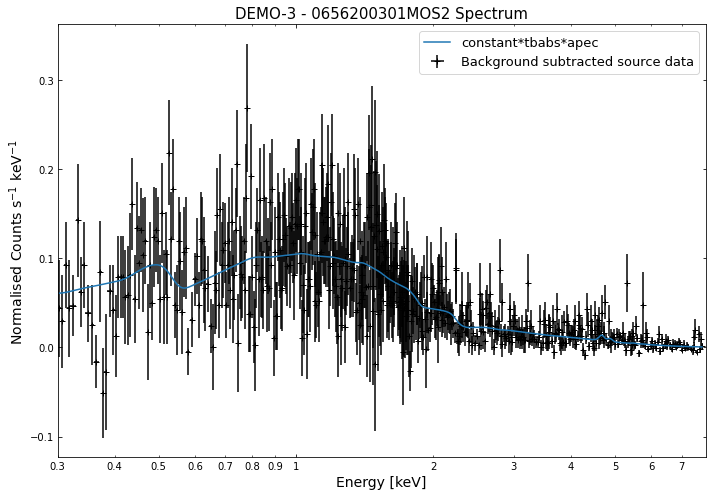

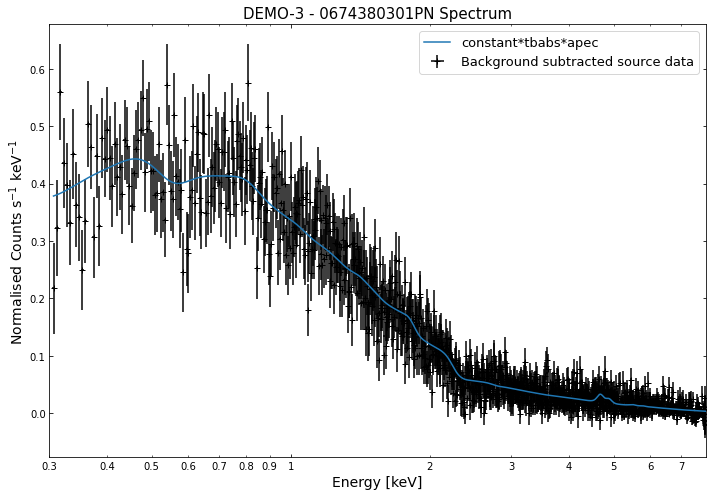

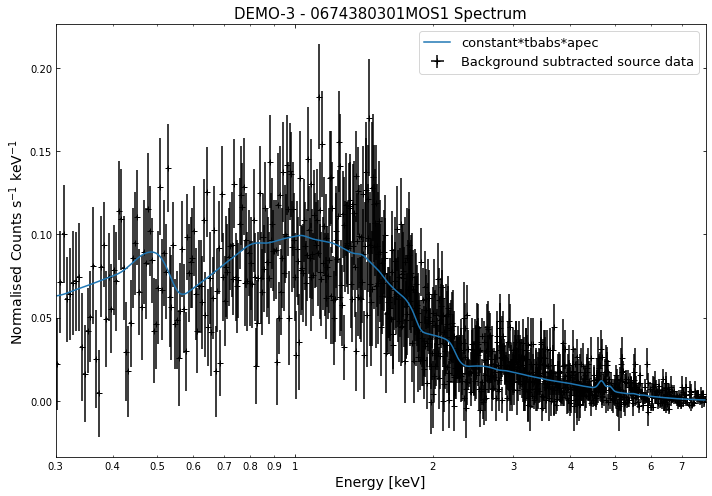

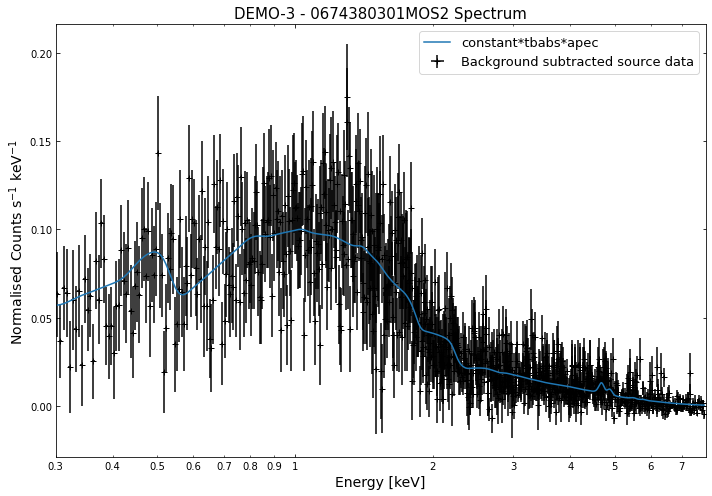

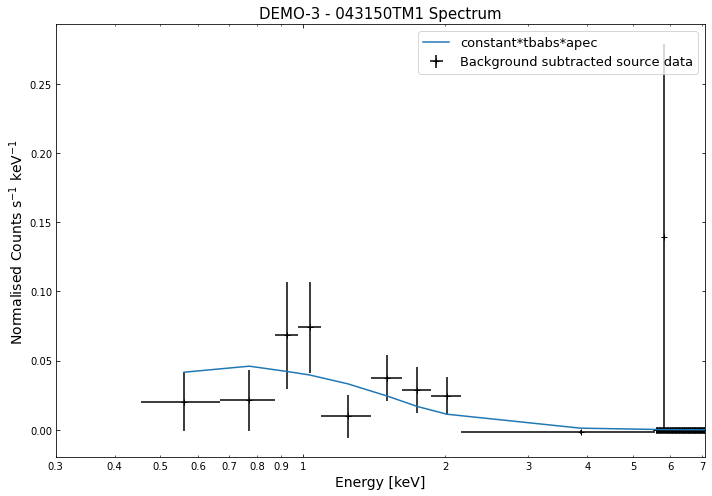

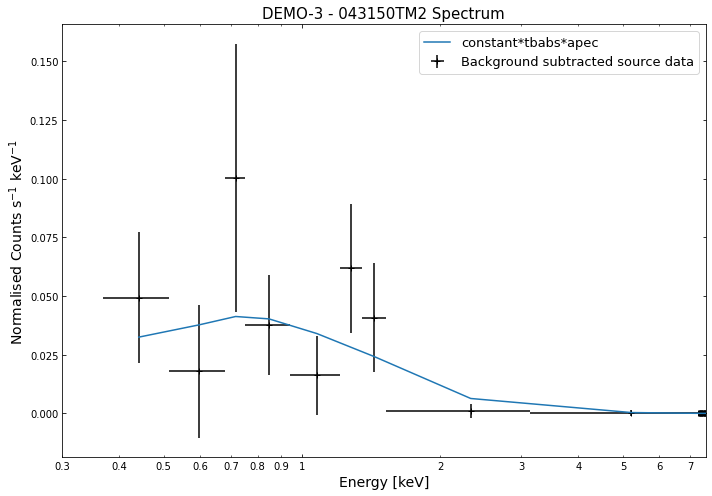

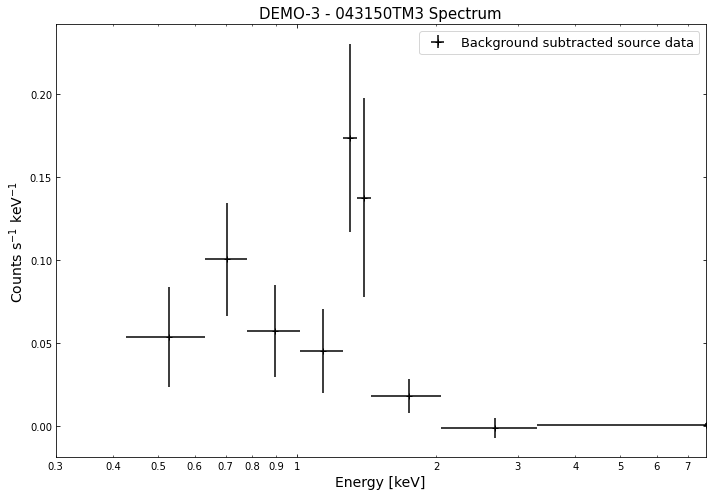

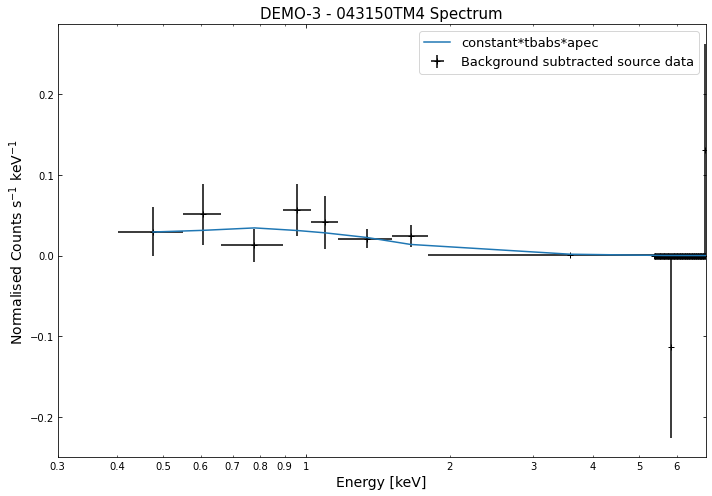

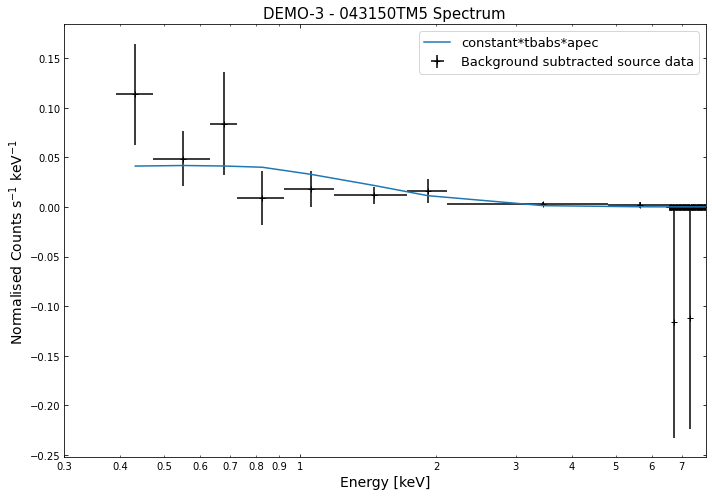

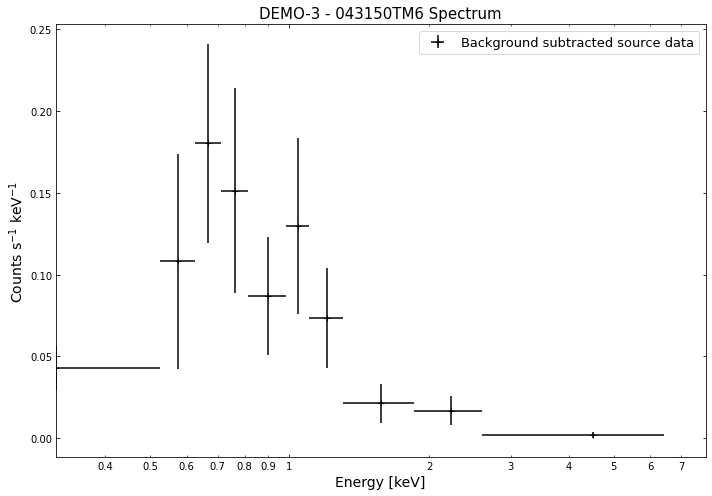

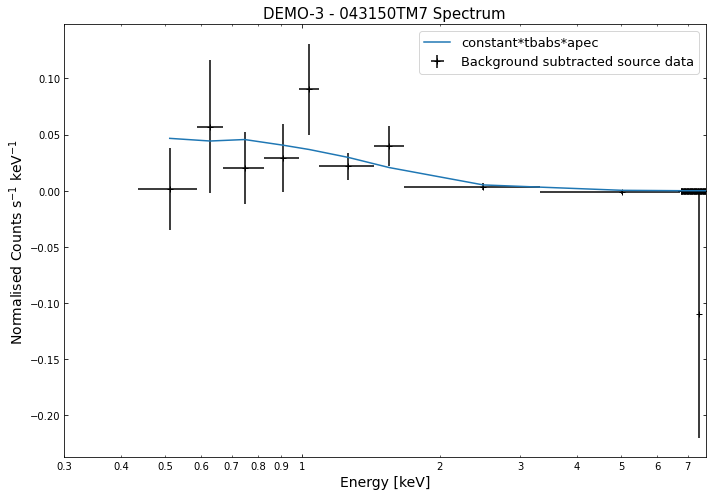

In [16]:
# Going through the R500 spectra
for sp in demo_smp[2].get_spectra('r500'):
    sp.view()
print('\n\n\n')

# Going through the core-excised spectra
for sp in demo_smp[2].get_spectra(demo_smp[2].r500, inner_radius=demo_smp[2].r500*0.15):
    sp.view()

By viewing the spectra, it can be seen that there is sparse data in individual spectra of the eROSITA instruments. Please see [the multi-mission tutorial](multimission.ipynb) for how best to fit to eROSITA spectra with XGA.

## General retrieval of fit parameters

Once we have performed a fit, we will almost certainly want to know what the values of the fit parameters (as well as the uncertainties on those parameters). It is a simple matter to retrieve these fit values, you only need to supply the name of the model and the region the fit was run on. This information is passed into the 'get_results' method of a source object, and a dictionary of parameter values + uncertainties will be returned. 

You must parse a telescope into any get_results function, as fits are performed for every associated telescope.

**The format of the returned dictionary is always as follows:**
{parameter name : array(\[parameter value, -error, + error \])}

For the quasar we have analysed as an example, the 'PhoIndex' entry is a numpy array with three values, the first column is the parameter value, the second column is the -error on the value, and the third column is the +error.

The 'factor' entry in the dictionary is the multiplicative constant we use to deal with differing normalisations of the separate spectra, there are only two entries (rather than the three you might expect due to there being three spectra) because one of them was set to one and frozen:

In [18]:
# Retrieving XMM fit results
demo_src.get_results('point', 'xmm', 'constant*tbabs*zpowerlw')

{'PhoIndex': array([1.93747   , 0.02159479, 0.02174787]),
 'norm': array([1.1396000e-03, 2.7399168e-05, 2.7834152e-05]),
 'factor': array([[0.923423  , 0.03567395, 0.03669737],
        [0.993745  , 0.03273724, 0.03366322]])}

In [19]:
# Retrieving eROSITA fit results
demo_src.get_results('point', 'erosita', 'constant*tbabs*zpowerlw')

{'PhoIndex': array([2.1628    , 0.05642148, 0.05709965]),
 'norm': array([0.00478608, 0.00029202, 0.00030638]),
 'factor': array([[0.870149  , 0.15153   , 0.16127018],
        [0.999455  , 0.1664201 , 0.17751245],
        [0.91332   , 0.14919215, 0.16594271],
        [1.26386   , 0.16899557, 0.18692674],
        [0.923803  , 0.14692723, 0.16400043],
        [0.724299  , 0.13657089, 0.15629746],
        [1.24919   , 0.16514585, 0.17846762],
        [0.999997  , 0.07309235, 0.07887822],
        [0.870381  , 0.15155162, 0.1611529 ],
        [0.999423  , 0.16643278, 0.1775114 ],
        [0.913319  , 0.14919132, 0.16594354],
        [1.26391   , 0.16899194, 0.18693557],
        [0.923971  , 0.14693902, 0.16401579],
        [0.724314  , 0.13657411, 0.15630026],
        [1.24885   , 0.16523051, 0.17854476]])}

We can also use the exact same method on a GalaxyCluster source we get from our ClusterSample object. It is important to note that only parameters that are allowed to vary during the fit are saved in the fit paramater dictionaries. If, when we called 'single_temp_apec', we had allowed the nH and metalicity to vary, they would also have entries in the dictionary returned below:

In [21]:
# Retrieving XMM fit results
demo_smp[2].get_results('r500', 'xmm', 'constant*tbabs*apec')

{'kT': array([8.41709   , 0.22842337, 0.23453062]),
 'norm': array([2.6363700e-03, 4.9085839e-05, 4.9354864e-05]),
 'factor': array([[0.918736  , 0.03059174, 0.0312602 ],
        [0.977164  , 0.02994199, 0.03068463],
        [1.00689   , 0.02015316, 0.02080244],
        [0.972574  , 0.02266166, 0.023306  ],
        [0.977971  , 0.02215037, 0.02279814]])}

In [22]:
# Retrieving eROSITA fit results
demo_smp[2].get_results('r500', 'erosita', 'constant*tbabs*apec')

{'kT': array([6.55572  , 1.9323957, 3.6358687]),
 'norm': array([0.00202203, 0.00016637, 0.00017598]),
 'factor': array([[1.0898    , 0.21588047, 0.24750644],
        [0.89863   , 0.24952652, 0.27624912],
        [0.932265  , 0.21676906, 0.24457866],
        [0.884394  , 0.22861677, 0.24116854]])}

Though do note that for a GalaxyCluster source object the model is set by default to constant\*tbabs\*apec, for convenience' sake, so you could just call `get_results` like this: (here the inner_radius information is added so we're retrieving the results for the core-excised spectra):

In [40]:
# For XMM
demo_smp[2].get_results(outer_radius=demo_smp[2].r500, 
                        telescope='xmm', 
                        inner_radius=demo_smp[2].r500*0.15)

{'kT': array([8.37921   , 0.25067152, 0.2544446 ]),
 'norm': array([2.3441900e-03, 4.7317978e-05, 4.7611244e-05]),
 'factor': array([[0.906131  , 0.03281977, 0.03359024],
        [0.975419  , 0.03233453, 0.03321516],
        [0.996542  , 0.02162084, 0.02237312],
        [0.964819  , 0.02439886, 0.02515823],
        [0.956829  , 0.02358943, 0.02434218]])}

In [41]:
# For eROSITA
demo_smp[2].get_results(outer_radius=demo_smp[2].r500, 
                        telescope='erosita', 
                        inner_radius=demo_smp[2].r500*0.15)

{'kT': array([ 7.53687   ,  3.62108397, 11.85223764]),
 'norm': array([0.00215221, 0.00044962, 0.0005073 ]),
 'factor': array([[0.847694  , 0.25734344, 0.31767118],
        [0.711802  , 0.23113918, 0.3026134 ],
        [0.767567  , 0.24254158, 0.32173972],
        [0.837628  , 0.24217521, 0.32238229]])}

## Parameters from GalaxyCluster and ClusterSample objects

Galaxy Clusters have methods to make the retrieval of things like the intra-cluster medium temperature as simple as possible, both from sources directly and samples of clusters.

Again the only information we need to provide are the name of the model and the region that the fit was run on. The method to use is `get_temperature`, and the default model it tries to get values for is 'constant\*tbabs\*apec':

In [31]:
# We take an individual GalaxyCluster source and retrieve its temperature and -+ temperature errors
print(demo_smp[2].get_temperature('r500', 'xmm')) # for XMM
print(demo_smp[2].get_temperature('r500', 'erosita')) # for eROSITA

[8.41709    0.22842337 0.23453062] keV
[6.55572   1.9323957 3.6358687] keV


When dealing with a sample of Galaxy Clusters however, we often wish to know the properties of the entire population, in which case we can use the 'Tx' method of the ClusterSample. Again the analysis radius must be passed, but the model is set by default to 'constant\*tbabs\*apec':

In [35]:
# This retrieves the T500 values (measured with constant*tbabs*apec) for the whole sample
print(demo_smp.Tx('xmm', 'r500')) # for XMM
print(demo_smp.Tx('erosita', 'r500')) # for eROSITA

[[6.29897    0.21561801 0.23316335]
 [8.39656    0.31073589 0.32612905]
 [8.41709    0.22842337 0.23453062]] keV
[[3.38312    1.08468493 2.12288981]
 [4.59979    0.74749357 1.09984058]
 [6.55572    1.9323957  3.6358687 ]] keV


## Retrieving L$_\rm{x}$ values from sources and samples

If a source has a redshift associated with it then L$_\rm{X}$ values will automatically be measured as part of the fitting process. The use of X-ray luminosities in analysis is extremely common in X-ray astronomy, hence there are methods to retrieve luminosities from any source or sample object, in much the same way as we retrieve T$_{\rm{x}}$ values from GalaxyCluster and ClusterSample objects.

Seeing as L$_\rm{X}$ values are measured within an energy band, it is necessary to define the lower and upper limits of the measurement that you wish to retrieve (as Astropy quantities) - in this case the bolometric luminosity. If no specific energy limits are supplied then the 'get_luminosities' method would supply all L$_\rm{X}$ measurements for the region-model combination in question.

Just as with the parameter dictionaries, the first column is the L$_\rm{X}$ value, the second is the -error, and the third is the +error:

In [42]:
lo_en = Quantity(0.01, 'keV')
hi_en = Quantity(100.0, 'keV')

In [45]:
# Grabbing the bolometric luminosity of the quasar we have investigated
# We just retrieve the XMM luminosities here
print(demo_src.get_luminosities('point', 'xmm', 'constant*tbabs*zpowerlw', lo_en=lo_en, hi_en=hi_en), '\n')

# And all the r500 luminosities of the first cluster in our sample
print(demo_smp[0].get_luminosities('r500', 'xmm', 'constant*tbabs*apec'))

[1.07376996e+46 2.92427442e+44 2.22516049e+44] erg / s 

{'bound_0.5-2.0': <Quantity [5.78162506e+44, 1.07061634e+43, 1.03436949e+43] erg / s>, 'bound_0.01-100.0': <Quantity [2.13059197e+45, 5.11181043e+43, 5.59492661e+43] erg / s>}


In much the same way we can retrieve L$_\rm{X}$ values for an entire sample, and please note that this method can be used with any type of sample, not just ClusterSample objects:

In [47]:
# Bolometric luminosities for our sample of clusters
print(demo_smp.Lx('r500', 'xmm', 'constant*tbabs*apec', lo_en=lo_en, hi_en=hi_en))

[[2.13059197e+45 5.11181043e+43 5.59492661e+43]
 [2.34605411e+45 4.33829684e+43 5.42820048e+43]
 [1.99951062e+45 4.51018972e+43 4.59315851e+43]] erg / s


Please see the [multi mission tutorial](multimission.ipynb) for details on the XMM returned luminosity values.

## Generating annular spectra

The generation and use of annular spectra is dealt with in an advanced tutorial.